In [1]:
import simos as sos
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### In this notebook, we will explore magnetic field effects in simple models of Spin-Correlated Radical Pairs. For a more basic introduction  please check out our introductory notebook on SCRP spin physics in a symbolic framework.




Photogenerated spin-correlated radical pairs (SCRPs) are entangled electron spin pairs formed in well-defined spin states.  They play an important role in a vast range of biological systems, typically as short lived intermediates in cascades of chemical transformations.
Although these reactions often involve free energy changes of several keV, the chemical faith of SCRPs can be highly susceptible to magnetic fields as low as only a few $\mu$- Tesla.  A prominent example is magnetoreception in migratory birds which is most likely mediated by blue-light photoreceptors in the birds retina.




### Magnetic field effects

To understand how the chemcial faith of SCRPS can be sensitive to even the smallest of magnetic fields, let us consider the following, most basic scheme:

In a first step, the excitation of a diamagnetic molecular precursor (ground state) is stimulated
by laser illumination with appropriate energy. Most molecular systems absorb light in the UV-green wavelength range. The excited state then undergoes electron transfer and charge separation resulting in the formation of the SCRP if the distance between the radicals is sufficiently restricted. Since
electron transfer is spin-conserving, the initial spin states of the radicals are highly correlated with their combined spin multiplicity equaling that of their common precursor. The lifetime of the SCRP is finite and may range from a few ns to several μs. Yet, for most systems, it is sufficiently
long to allow for an inter-system crossing (ISC) between the singlet and triplet manifolds of the SCRP to occur.  Since the ISC alters the spin multiplicity, it directly influences
the chemical faith of the SCRP via spin-selective chemical reaction.If the charge separated state is
quenched upon chemical reaction, external fields may alter the relative yields of singlet and triplet products. This very basic concept holds for any variant of the scheme outlined here, e.g. for systems involving multiple electron transfer steps or additional pathways for long-lived fluorescence.

The  ISC is mediated by differences in the radical pairs Larmor-frequencies and asymmetries in their hyperfine coupling networks. The rate of the ISC is therefore sensitive to magnetic fields - even of very small magnitude - and that's how the MFE arises.


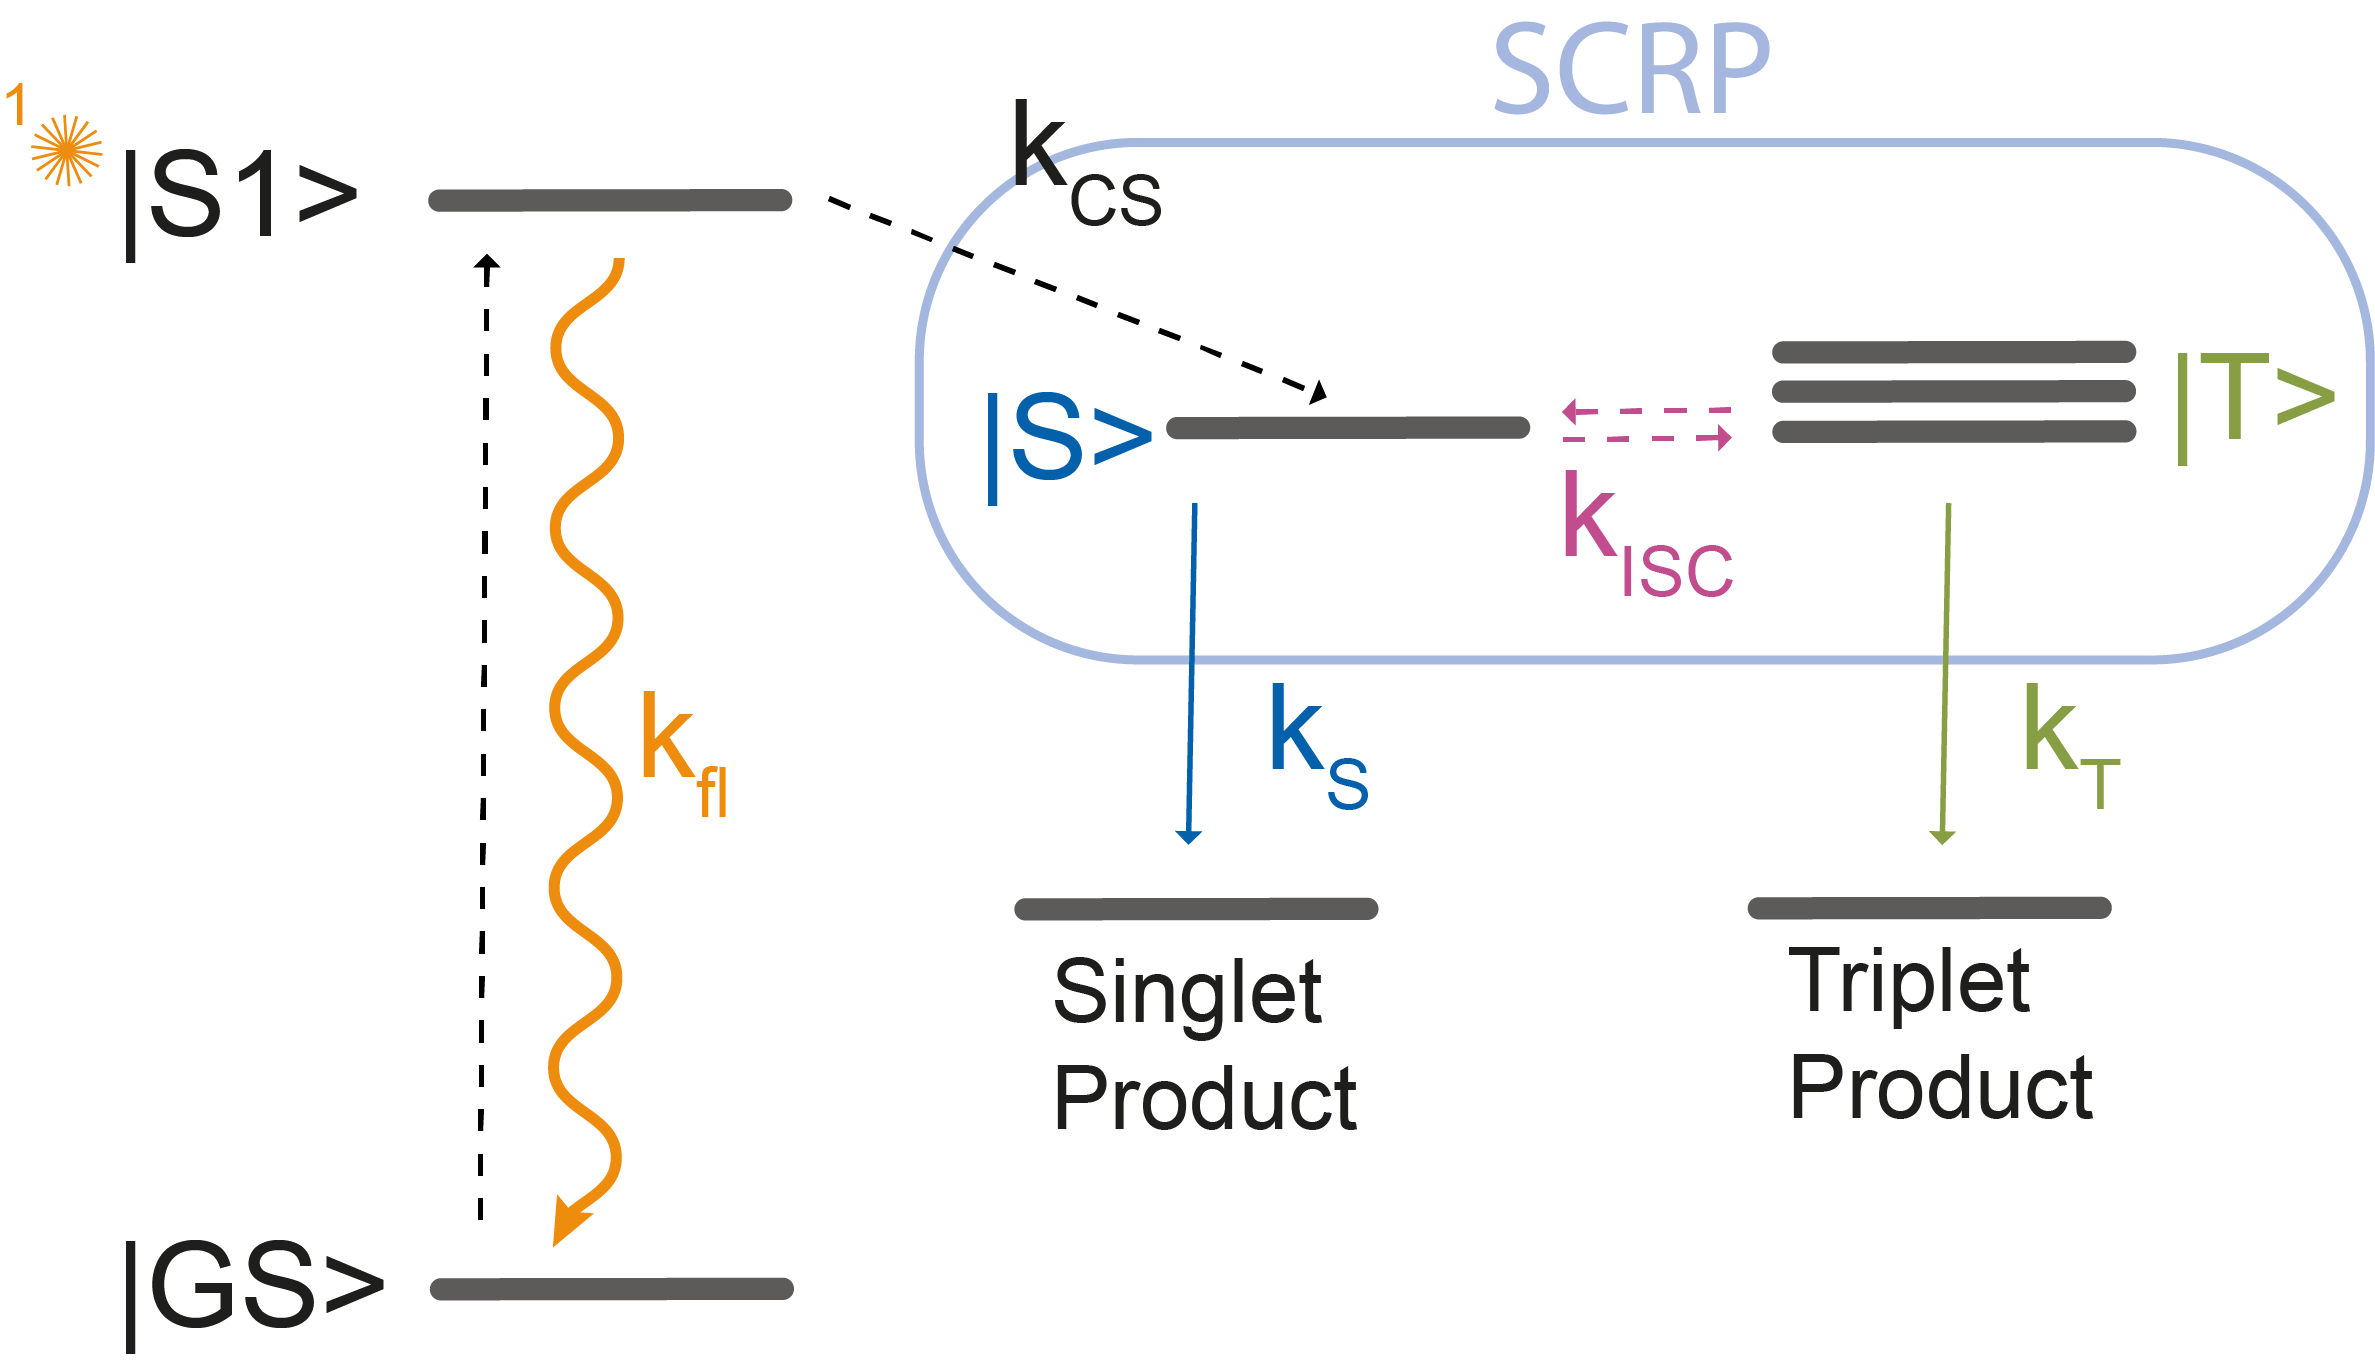

In [1]:
from IPython.display import Image
Image(filename='img/examples_SCRP1.png', width=500)

A common descriptor of MFEs are the singlet and triplet fractions $\phi_X$ ($X = S,T$), that define the relative amounts of singlet and triplet products.  Generally, simulation of $\phi_X$ ($X = S,T$) requires a quantum master equation, allowing for simultaneous simulation of coherent spin dynamics and incohrent optical excitation and chemical reactive pathways. 

A notable exception is the special case of SCRP recombination with identical rates $k_S = k_T = k$ for singlet and triplet states. In this case, singlet and triplet yields ($X = S, T_0, T_+, T_-$) can be obtained as 

\begin{equation}
\phi_X = k\int_0^{\infty} P_X(t) e^{-kt} dt 
\end{equation}

using the singlet and triplet probabilities $P_X(t)$ obtained in a simulation of coherent dynamics by means of a simple Liouville-von-Neumann equation. In this notebook we work under the assumption $k_S = k_T = k$  to make use of this simplifcation. 


### Weakly Coupled Systems and the Low Field Effect

In weakly coupled systems  differences in g-factors  and in hyperfine interactions  exceed the dipolar and exchange couplings of the electron spins of the radical pair ($\Delta g, \Delta A \geq J, d $).   

At zero field ($B_0 = 0$) all states are nearly degenerate and hyperfine interactions mediate transitions between all spin levels. The application of a weak magnetic field reduces the singlet yield of a singlet-born radical by enhancing $\ket{S_0}-\ket{T_{0}}$ interconversion, a phenomenon commonly referred to as the $\textbf{low-field-effect}$. 

At high fields, spin evolution is a pure zero-quantum dynamics as the zero quantum subspace is then well separated in energy from the double quantum states.  Both, hyperfine interactions and g-factor differences contribute to rapid $\ket{S}-\ket{T_0}$ interconversion but do not mediate any conversion with the  $\ket{T_{\pm 1}}$ states.

We will now try to reproduce this behavior in simulation. 
In a first step, we generate a simple radical pair system and define our singlet and triplet states.

Further reading:  J. Chem. Phys. 149, 034103 (2018) 

In [2]:
A = {'val': 1/2, 'name':'A'}
B = {'val': 1/2 , 'name':'B'}
H =  {'val': 1/2 , 'name':'H'}
rp = sos.System( [A,B,H], method = "numpy")
rp.add_ghostspin("C", ["A", "B"])

S =  (rp.C_1p[0].unit())   # singlet case 
T0 =  (rp.C_3p[0].unit()) # triplet 0
Tp =   (rp.C_3p[1].unit()) # triplet 1
Tm =   (rp.C_3p[-1].unit()) # triplet 1

We define the strengths of all interactions and initialise the Hamiltonian. 

In [3]:
yH = sos.yH1
yA = sos.ye
yB = sos.ye
a = sos.f2w(10e7) 
k = a/2
J=  25e-3*sos.ye

# A Hyperfine interaction between Spins A and H 
Hhfi = a*(rp.Ax*rp.Hx + rp.Ay*rp.Hy + rp.Az*rp.Hz)
# A J-Couplign between Spins A and B
HJ = J*(rp.Ax*rp.Bx + rp.Ay*rp.By + rp.Az*rp.Bz)
# The Zeeman Hamiltonian
HZ = lambda B: yH*B*rp.Hz + yA*B*rp.Az + yB*B*rp.Bz 

We simulate the time evolution of the radical pair at zero and a low magnetic field and evaluate the singlet and triplet probabilities. 

RUNTIME  : ca. 10 seconds

In [4]:
# Magnetic fields, 0 and 1 mT
Bs = [0, 3e-3, 30e-3] 

# time axis for evolution 
dt = 0.05e-9
N = 1000
t = np.arange(0, N*dt, dt)

# Cache the propagator for the time evolution at all fields
Us = np.empty(len(Bs), dtype = object)
for ind_B, B in enumerate(Bs):
    H = Hhfi + HZ(B)
    Us[ind_B] = sos.evol(H, dt)

# Define the intial state
rho0 =  rp.C_1p[0]

# Define the observables 
observables = [S, Tm, T0, Tp]
Ps = np.empty((len(Bs), len(observables), len(t)), dtype = complex )

# Evolve and observe
for ind_B, B in enumerate(Bs):
    U = Us[ind_B]
    rho = rho0.copy()
    for i in range(len(t)):
        for ind_o, o in enumerate(observables):
            Ps[ind_B, ind_o, i] = sos.expect(rho, o)
        rho = U*rho*U.dag()


# Add chemical reaction
Ps_rct = np.multiply(Ps, np.exp(-k*t))

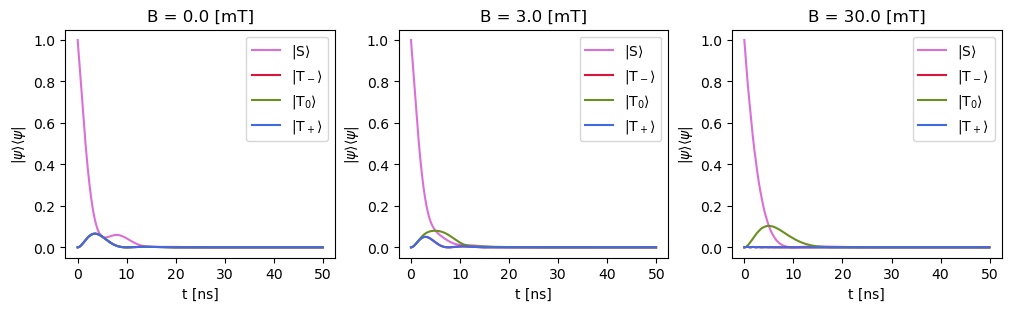

In [5]:
labels = [r"|S$\rangle$", r"|T$_-\rangle$", r"|T$_0\rangle$", r"|T$_+\rangle$"]
colors = ["orchid", "crimson", "olivedrab", "royalblue"]
titles = [str(Bi/1e-3) for Bi in Bs]
fig, ax = plt.subplots(1, len(Bs), figsize = (10,3), layout = "constrained")
for ind_a, a in enumerate(ax):
    for i in range(len(observables)):
        a.plot(t/1e-9, np.real(Ps_rct[ind_a, i, :]), color = colors[i], label = labels[i])
        a.legend()
        a.set_xlabel(r"t [ns]")
        a.set_ylabel(r"|$\psi\rangle$$\langle\psi$|")
        a.set_title("B = "+ titles[ind_a] + " [mT]")

We now repeat this simulation screen a larger set of magnetic fields and evaluate the singlet fraction for each field.

RUTNIME: ca. 1 Minute. 

In [6]:
# Magnetic fields, a range.
Bs = np.arange(0, 25e-3, 1e-3)

# The time axis for evolution.
dt = 0.05e-9
N = 1000
t = np.arange(0, N*dt, dt)

# Cache the propagator for the time evolution at all fields.
Us = np.empty(len(Bs), dtype = object)
for ind_B, B in enumerate(Bs):
    H = Hhfi + HZ(B)
    Us[ind_B] = sos.evol(H, dt)

# Define the intial state.
rho0 = rp.C_1p[0]

# Define the observables. 
observables = [S, Tm, T0, Tp]
Ps = np.empty((len(Bs), len(observables), N), dtype = complex )

# Evolve and observe.
for ind_B in sos.bar(range(len(Bs))):
    U = Us[ind_B]
    rho = rho0.copy()
    for i in range(N):
        for ind_o, o in enumerate(observables):
            Ps[ind_B, ind_o, i] = sos.expect(rho, o)
        rho = U*rho*U.dag()

# Add chemical reaction.
Ps_rct = np.multiply(Ps, np.exp(-k*t))
# Evaluate overall singlet and triplet yields. 
phis = k*np.sum(Ps_rct*dt, axis = 2)

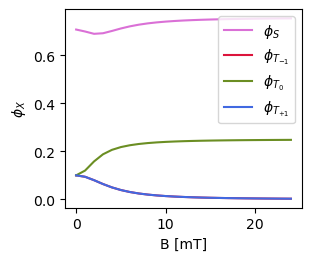

In [7]:
labels = [r"$\phi_S$", r"$\phi_{T_{-1}}$", r"$\phi_{T_{0}}$", r"$\phi_{T_{+1}}$"]
colors = ["orchid", "crimson", "olivedrab", "royalblue"]
fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")
a = ax
for i in range(len(observables)):
    a.plot(Bs/1e-3, np.abs(phis[:, i]), color = colors[i], label = labels[i])
    a.legend(loc = "upper right")
    a.set_xlabel(r"B [mT]")
    a.set_ylabel(r"$\phi_X$")
    #a.set_title("B = "+ titles[ind_a] + " [mT]")
    #a.set_ylim([-0.1,1.1])

In [8]:
fig.savefig("simplemfe.pdf")

### Strongly Coupled Systems and the 2J Resonance 

We will now perform the analogous calculation, but here we add a strong J coupling as the dominant component of the system Hamiltonian. 

For strongly coupled systems, where exchange and dipolar couplings are of similar magnitude or even larger than $\Delta g$ and $\Delta A$, the situation is more complicated. At zero or low magnetic fields, the singlet and triplet manifolds of the pair are well separated, thereby suppressing efficient singlet--triplet inter conversion. However, when the strength of the applied magnetic field equals the magnitude of the electron--electron spin coupling, one of the $T_{\pm 1}$ states is brought in resonance with the $\ket{S}$ state and hyperfine-mediated singlet-triplet interconversion is facilitated. This effect, commonly known as 2J-resonance has been experimentally demonstrated and utilized to determine the magnitude of the exchange coupling of SCRPs.


In [9]:
# Magnetic fields, a range.
Bs = np.arange(0, 100e-3, 1e-3)

# The time axis for evolution.
dt = 0.05e-9
N = 1000
t = np.arange(0, N*dt, dt)

# Cache the propagator for the time evolution at all fields.
Us = np.empty(len(Bs), dtype = object)
for ind_B, B in enumerate(Bs):
    H = HJ + Hhfi + HZ(B)
    Us[ind_B] = sos.evol(H, dt)

# Define the intial state.
rho0 = rp.C_1p[0]

# Define the observables. 
observables = [S, Tm, T0, Tp]
Ps = np.empty((len(Bs), len(observables), N), dtype = complex )

# Evolve and observe.
for ind_B in sos.bar(range(len(Bs))):
    U = Us[ind_B]
    rho = rho0.copy()
    for i in range(N):
        for ind_o, o in enumerate(observables):
            Ps[ind_B, ind_o, i] = sos.expect(rho, o)
        rho = U*rho*U.dag()

# Add chemical reaction.
Ps_rct = np.multiply(Ps, np.exp(-k*t))
# Evaluate overall singlet and triplet yields. 
phis = k*np.sum(Ps_rct*dt, axis = 2)

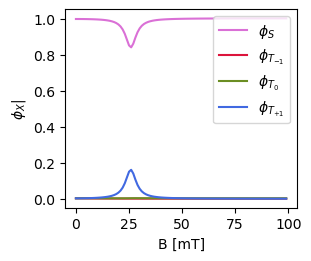

In [11]:
labels = [r"$\phi_S$", r"$\phi_{T_{-1}}$", r"$\phi_{T_{0}}$", r"$\phi_{T_{+1}}$"]
colors = ["orchid", "crimson", "olivedrab", "royalblue"]
fig, ax = plt.subplots(1, 1, figsize = (3,2.5), layout = "constrained")
a = ax
for i in range(len(observables)):
    a.plot(Bs/1e-3, np.abs(phis[:, i]), color = colors[i], label = labels[i])
    a.legend(loc = "upper right")
    a.set_xlabel(r"B [mT]")
    a.set_ylabel(r"$\phi_X$|")